In [174]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm #linear regression tool
from sklearn import tree
from sklearn import preprocessing #for normalizing values
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt # for visualizations
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns # for visualizations
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [100]:
#read the csv to a dataframe
df = pd.read_csv("../data/salary-cap-data.csv", encoding= 'utf-8')
df.info() #check to ensure it worked
df.head(2)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Team            192 non-null    object 
 1   Year            192 non-null    int64  
 2   Wins            192 non-null    int64  
 3   Losses          192 non-null    int64  
 4   Ties            192 non-null    int64  
 5   Classification  192 non-null    object 
 6   QB              192 non-null    float64
 7   RB              192 non-null    float64
 8   WR              192 non-null    float64
 9   TE              192 non-null    float64
 10  OL              192 non-null    float64
 11  Offense         192 non-null    float64
 12  DL              192 non-null    float64
 13  LB              192 non-null    float64
 14  S               192 non-null    float64
 15  CB              192 non-null    float64
 16  Defense         192 non-null    float64
 17  SpecialTeams    192 non-null    flo

,Team,Year,Wins,Losses,Ties,Classification,QB,RB,WR,TE,...,DL,LB,S,CB,Defense,SpecialTeams,DeadMoney,Total,CapMax,PercentUsed
0,49ers,2013,12,4,0,Good,2843160.0,9257768.0,16945177.0,10569598.0,...,11028483.0,17860800.0,10696955.0,12885741.0,52471979.0,6831666.0,6601496.0,116398504.0,123000000.0,0.946329
1,Bears,2013,8,8,0,Mediocre,11276471.0,12036166.0,16580067.0,2495000.0,...,29744128.0,12474915.0,3802254.0,15375000.0,61396297.0,6290000.0,2854947.0,120145053.0,123000000.0,0.976789


In [256]:
X_train, X_test = train_test_split(df, test_size = 0.2) # splits the data into two parts with 1:4 ratio
print(X_train.shape)
print(X_test.shape)

(153, 32)
(39, 32)


In [257]:
#set the training and testing data
X = X_train[['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']]
y = X_train.Wins
X = sm.add_constant(X) #add the constant to the model
mod = sm.OLS(y, X, hasconst= True) #create the ordinary least squares model
res = mod.fit() #fit the model
print(res.summary()) #summarize the model

                            OLS Regression Results                            
Dep. Variable:                   Wins   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     4.689
Date:                Sun, 11 Oct 2020   Prob (F-statistic):           4.28e-06
Time:                        14:35:56   Log-Likelihood:                -365.57
No. Observations:                 153   AIC:                             755.1
Df Residuals:                     141   BIC:                             791.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -6.3720      2.497     -2.551   

In [103]:
Xtest = X_test[['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']]
ytest = X_test.Wins
Xtest = sm.add_constant(Xtest)

res.predict(Xtest);

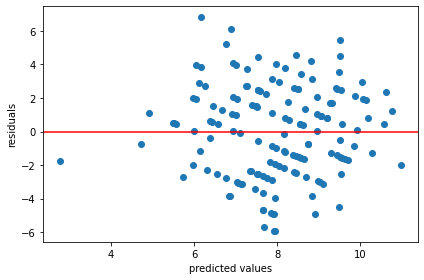

In [104]:
residuals = res.resid

y_pred = res.predict(X)
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color = 'red', label = '0')

plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.tight_layout()

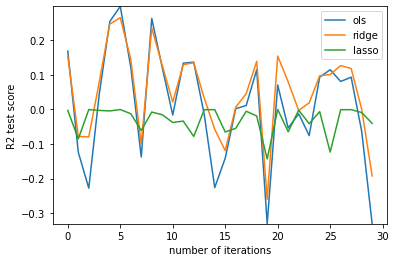

In [278]:
#in this model, there is collinearity between the different features - they are not entirely independent
#for example, if a team spends more on a quarterback, they will have to spend less elsewhere.. what they spend
#on a certain position depends on what they spent on the rest.
#for that reason, ridge or lasso regression may give better results than the standard linear regression
#lets try it out below...
def model_experiment(num_iter = 5, 
                     models = ['ols', 'ridge', 'lasso'], alpha= 10, 
                     complexity = 'simple', degree = 3):
    
    X_train, X_test = train_test_split(df, test_size = 0.2) # splits the data into two parts with 1:4 ratio
    X = X_train[['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams', 'PercentUsed']]
    y = X_train.Wins
    
    x_axis = np.arange(num_iter)
    y_ols_test = []
    y_lasso_test = []
    y_ridge_test = []
    sample_models = {}
    for i in range(num_iter):
        
        if complexity == 'simple':
            ## split train_test 
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
        elif complexity == 'polynomial':
            ## Create higher order terms
            poly = PolynomialFeatures(degree=degree)
            Xp = poly.fit_transform(X)
            ## test-train split
            X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size = 0.2)


        ## Standard scale mean = 0, variance = 1
        sd = StandardScaler()

        sd.fit(X_train)

        X_train = sd.transform(X_train)

        X_test = sd.transform(X_test)

        ## Be careful about the leakage

        ## Vanilla model
        if 'ols' in models:
            lr = LinearRegression()

            lr.fit(X_train, y_train)
            
            sample_models['ols'] = lr

            test_score = lr.score(X_test, y_test)
            train_score = lr.score(X_train, y_train)

            y_ols_test.append(test_score)

    #       print('test score OLS is %.2f and train score is %.2f'%(test_score, train_score))

        if 'ridge' in models:
            ## Ridge in the simple setting
            ridge = Ridge(alpha = alpha, max_iter= 10000)
            ridge.fit(X_train, y_train)
            sample_models['ridge'] = ridge
            y_ridge_test.append(ridge.score(X_test, y_test))
    #         print('test score Ridge is %.2f and train score is %.2f'%(ridge.score(X_test, y_test),
    #                                                             ridge.score(X_train, y_train)))

        if 'lasso' in models:
            ## Lasso in the simple setting
            lasso = Lasso(alpha = alpha, max_iter= 10000)

            lasso.fit(X_train, y_train)
            
            sample_models['lasso'] = lasso
            
            y_lasso_test.append(lasso.score(X_test, y_test))
    #       print('test score Lasso is %.2f and train score is %.2f'%(lasso.score(X_test, y_test),
    #                                                             lasso.score(X_train, y_train)))

        i+=1
    if 'ols' in models:
        plt.plot(y_ols_test, label = 'ols')
    if 'ridge' in models:
        plt.plot(y_ridge_test, label = 'ridge')
    if 'lasso' in models:
        plt.plot(y_lasso_test, label = 'lasso')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    all_results = y_ols_test + y_lasso_test + y_ridge_test
    plt.ylim((np.min(all_results), np.max(all_results)))
    
    plt.legend()
    return sample_models

trained_models = model_experiment(num_iter=30, alpha = 30,
                                   models = ['ols', 'ridge', 'lasso'], 
                                   complexity= 'simple', degree = 3)


In [106]:
# After run model_experiment with complexity == 'polynomial'

lr_ols = trained_models['ols']
lr_lasso = trained_models['lasso']
lr_ridge =trained_models['ridge']

# check the coefficients from Lasso

print(lr_ridge.coef_)
print(lr_lasso.coef_)

# compare them with OLS/Ridge models.

[ 0.00000000e+00  0.00000000e+00  1.50656125e-01  7.32507480e-02
  6.19207517e-02 -7.59661251e-02 -1.16138193e-01  4.81865921e-03
  7.04657102e-02  2.30089248e-02  7.27893737e-02 -1.40358481e-01
  2.03953432e-01  0.00000000e+00  1.50656125e-01  7.32507480e-02
  6.19207517e-02 -7.59661251e-02 -1.16138193e-01  4.81865921e-03
  7.04657102e-02  2.30089248e-02  7.27893737e-02 -1.40358481e-01
  2.03953432e-01  6.49661420e-02 -1.37577552e-02 -3.16591734e-03
  4.92193687e-02  2.52138856e-04  5.67550971e-02  1.06892691e-02
  2.38675302e-02  2.49301035e-01 -4.27255838e-04  1.17355215e-01
  1.16072055e-01  5.41242980e-02 -3.50439563e-02  1.93218912e-02
 -1.46320333e-01  2.02199950e-01  1.04139103e-01 -4.50300310e-02
 -8.74295768e-02 -1.51535810e-02  1.50337472e-02  1.37734436e-01
  5.46452073e-02 -2.98083404e-02 -8.88791972e-02 -3.32446262e-02
  1.62030429e-02 -3.94154749e-02  3.86716139e-02 -8.80100900e-02
  6.42345156e-02 -1.44525365e-02 -7.77037202e-02  3.00185632e-02
 -9.55221179e-02 -8.61841

In [118]:
def normalize(x, col_max, col_min):
    return ((x - col_min) / (col_max - col_min))

#normalize the values for each position
for position in ['QB','RB', 'WR', 'TE', 'OL', 'DL', 'LB', 'S', 'CB', 'SpecialTeams']:
    df['norm' + position] = df[position].apply(lambda x: normalize(x, df[position].max(), df[position].min()))
df.head(2)

,Team,Year,Wins,Losses,Ties,Classification,QB,RB,WR,TE,...,normQB,normRB,normWR,normTE,normOL,normDL,normLB,normS,normCB,normSpecialTeams
0,49ers,2013,12,4,0,Good,2843160.0,9257768.0,16945177.0,10569598.0,...,0.045792,0.496506,0.445637,0.601705,0.303146,0.124968,0.362279,0.347406,0.365889,0.631449
1,Bears,2013,8,8,0,Mediocre,11276471.0,12036166.0,16580067.0,2495000.0,...,0.273408,0.672399,0.433855,0.080535,0.102124,0.519290,0.223023,0.058773,0.448341,0.571961


In [119]:
#lets try linear regression again
X_train, X_test = train_test_split(df, test_size = 0.2) # splits the data into two parts with 1:4 ratio
print(X_train.shape)
print(X_test.shape)

(153, 32)
(39, 32)


In [120]:
#set the training and testing data
X = X_train[['normQB','normRB', 'normWR', 'normTE', 'normOL', 'normDL', 'normLB', 'normS', 'normCB', 'normSpecialTeams', 'PercentUsed']]
y = X_train.Wins
X = sm.add_constant(X) #add the constant to the model
mod = sm.OLS(y, X, hasconst= True) #create the ordinary least squares model
res = mod.fit() #fit the model
print(res.summary()) #summarize the model


#####
#NOTE:
#it turns out this is no better than the original model - normalizing in this way doesn't do anything just makes
#the coeficients larger as the feature values are smaller which does nothing for the accuracy
#Probably an experiment that did not need to be done...
#####

                            OLS Regression Results                            
Dep. Variable:                   Wins   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     2.826
Date:                Sat, 10 Oct 2020   Prob (F-statistic):            0.00229
Time:                        17:43:01   Log-Likelihood:                -375.95
No. Observations:                 153   AIC:                             775.9
Df Residuals:                     141   BIC:                             812.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.5816      2.718  

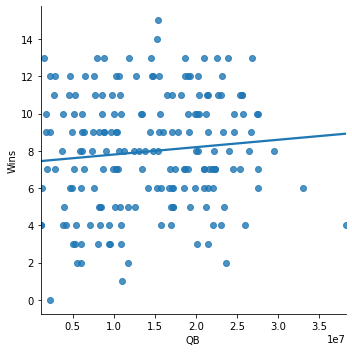

In [122]:
## let's use seaborn to plot a regression line
sns.lmplot(x = 'QB', y = 'Wins', data = df, ci = 0)
plt.draw()

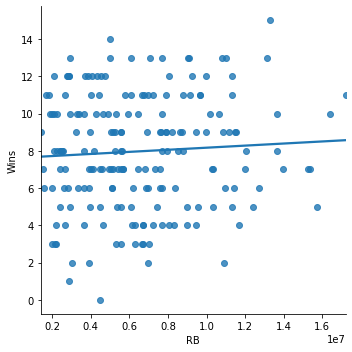

In [125]:
## let's use seaborn to plot a regression line
sns.lmplot(x = 'RB', y = 'Wins', data = df, ci = 0)
plt.draw()

In [137]:
def draw_tree(estimator, figsize =(15, 5), feature_names = ["Hits", "Years"]):
    """
    Takes a decision  tree estimator and plots it's tree structure
    :param estimator: A sklearn decision tree estimator. Should be fitted.
    :param figsize: tuple. (int, int).
    :param feature_names:
    :return: It returns a plot. The image is not saved.
    """
    fig = plt.figure(figsize= figsize)
    _ = tree.plot_tree(estimator,
                       feature_names= feature_names,
                       filled=True)

           QB          RB          WR          TE          OL          DL  \
0   2843160.0   9257768.0  16945177.0  10569598.0  17479156.0  11028483.0   
1  11276471.0  12036166.0  16580067.0   2495000.0  10071052.0  29744128.0   

           LB           S          CB  SpecialTeams  PercentUsed  
0  17860800.0  10696955.0  12885741.0     6831666.0     0.946329  
1  12474915.0   3802254.0  15375000.0     6290000.0     0.976789  
[[ 2  2 11]
 [ 0  4  7]
 [ 0  4  9]]
              precision    recall  f1-score   support

         Bad       1.00      0.13      0.24        15
        Good       0.40      0.36      0.38        11
    Mediocre       0.33      0.69      0.45        13

    accuracy                           0.38        39
   macro avg       0.58      0.40      0.36        39
weighted avg       0.61      0.38      0.35        39



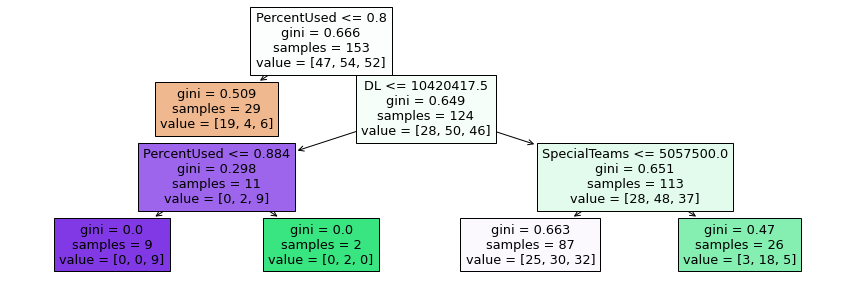

In [254]:
## here let's apply sklearn DecisionTreeClassifier
X = df.drop(['Team', 'Year', 'Wins', 'Losses', 'Ties', 'Classification', 'Offense', 'Defense', 'Total', 'DeadMoney', 'CapMax', 'normQB','normRB', 'normWR', 'normTE', 'normOL', 'normDL', 'normLB', 'normS', 'normCB', 'normSpecialTeams'], axis=1)
y = df['Classification']
print(X.head(2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

classifier = DecisionTreeClassifier(max_leaf_nodes= 5)
#classifier = DecisionTreeClassifier(max_depth=None)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

draw_tree(classifier,feature_names= X_train.columns)


In [280]:
depth = []
for i in range(3,100):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    # Perform 7-fold cross validation 
    scores = cross_val_score(estimator=clf, X=x, y=y, cv=10, n_jobs=4)
    depth.append((i,scores.mean()))
print(depth)

ValueError: Found input variables with inconsistent numbers of samples: [192, 153]

In [252]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

## here let's apply sklearn DecisionTreeClassifier
X = df.drop(['Team', 'Year', 'Wins', 'Losses', 'Ties', 'Classification', 'Offense', 'Defense', 'Total', 'DeadMoney', 'CapMax', 'normQB','normRB', 'normWR', 'normTE', 'normOL', 'normDL', 'normLB', 'normS', 'normCB', 'normSpecialTeams'], axis=1)
y = df['Classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3076923076923077


In [242]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=70, seed=101)
fit(X_train, y_train)
predicted = xgb.predict_proba(X_test)

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/ZachV/opt/anaconda3/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']
